# Assignment 2 [78 pts]
The objective for this assignment is to apply:
* Linear regression
* Evaluate model performance using different methods
* Tunning parameters
* Use L1-L2 regularization
* Gradient descendet and sochastic gradient descendent

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns

## PART 1. INTERPRETATION [24 pts]

For this part, we will use the Linear Regression from statmodels class https://www.statsmodels.org/stable/regression.html

In [27]:
import statsmodels.api as sm

### Data Description:
Forced expiratory volume (FEV) is an index of pulmonary function that measures the volume of air expelled after one second of constant effort. The data set contains FEV determinations of 654 children seen in the Childhood Respiratory Disease Study, which aimed to detect factors related to pulmonary function in children. The data set comprises the following variables:

* Age: Subject Age (in years)
* FEV: Forced Expiratory Volume (liters)
* Height: Subject Height (inches)
* Sex: Subject Gender, 0 = female / 1 = male
* Smoke: Subject Smoking Status, 0= not a current smoker / 1 = current smoker

First, let's load the data.

In [31]:
fev = pd.read_csv("./fev.csv")
# Printing head
fev.head()

,age,height,sex,smoke,fev
0,9,57.0,0,0,1.708
1,8,67.5,0,0,1.724
2,7,54.5,0,0,1.720
3,9,53.0,1,0,1.558
4,9,57.0,1,0,1.895


For our regression, `fev` is our response variable, and the remaining variables are the independent variables (or predictors)

In [34]:
varNames = fev.columns[:-1]
responseVar = fev.columns[-1]

In [36]:
print(varNames)
print(responseVar)

Index(['age', 'height', 'sex', 'smoke'], dtype='object')
fev


**[6 pts]** Fit a regression model using OLS from the `statsmodels.api`. Remember that to use linear regression, we need to attach a column of ones to the features. In statmodels, we can do that using `sm.add_constant`. 

In [39]:
# TO DO
x = sm.add_constant(fev[varNames])
y= fev[responseVar]
model = sm.OLS(y,x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    fev   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     560.0
Date:                Tue, 11 Mar 2025   Prob (F-statistic):          9.10e-209
Time:                        10:53:04   Log-Likelihood:                -345.90
No. Observations:                 654   AIC:                             701.8
Df Residuals:                     649   BIC:                             724.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.4570      0.223    -20.001      0.0

**[5 pts]** Based on the report provided by the OLS model, answer the following questions.

1. Is there a relationship between the predictors and the response?
2. How strong is the relationship between the predictors and the response?
3. Which predictors appear to have a statistically significant relationship to the response?
4. Are boys or girls more likely to have higher FEV? Why? 

In [42]:
#1. Yes. There is a relationship between the predictors and the response.
#2. R-square value 0.775 indicate that 77.5 % of the variance in fev is explained by the model.
#3.age , height and sex has P value less than 0.05 and they have a statistically significant relationship to the response.
#4. Yes becuase coefficient of sex is 0.15 
#4.Therefore when female = 0 and boy = 1, boys are likely to have higher FEV than girl by 1.1701 times. 


## Colliniarity among variable

In statistics, correlation or dependence is any statistical relationship, whether causal or not, between two random variables or bivariate data. Although in the broadest sense, "correlation" may indicate any type of association, in statistics it usually refers to the degree to which a pair of variables are linearly related. [Correlation Wikipedia Page](https://en.wikipedia.org/wiki/Correlation)

Before fitting our regression model, it is crucial to assess whether the variables are correlated with each other. This is because when two or more predictor variables exhibit strong correlations, it can pose challenges in the regression analysis. In such cases, it becomes difficult to distinguish the individual effects of collinear variables on the response variable.

We can use the .cor() method from pandas for calculating the correlation among the variables.

             age    height       sex     smoke       fev
age     1.000000  0.791944  0.029144  0.404252  0.756459
height  0.791944  1.000000  0.159029  0.280387  0.868135
sex     0.029144  0.159029  1.000000 -0.075612  0.208415
smoke   0.404252  0.280387 -0.075612  1.000000  0.245425
fev     0.756459  0.868135  0.208415  0.245425  1.000000


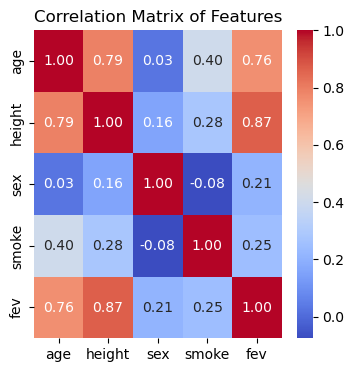

In [46]:
# calculating correlation
correlation_matrix = fev.corr()

print(correlation_matrix)

#visualizing correlation
plt.figure(figsize=(4, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

In [48]:
#converting correlation dataframe to numpy matrix
correlationMatrix = correlation_matrix.to_numpy()

correlationMatrix_predictor = correlationMatrix[:-1,:-1]
correlationMatrix_response = correlationMatrix[-1,:-1]

print('shape of correlationMatrix_predictor {} and correlationMatrix_response {}'.format(correlationMatrix_predictor.shape, correlationMatrix_response.shape )  )

shape of correlationMatrix_predictor (4, 4) and correlationMatrix_response (4,)


Let's create a function with arguments `correlationMatrix_predictor`, `correlationMatrix_response`, and the variable names. This function will identify variables with a correlation higher than a specified threshold (e.g., 0.5) and retain only the variable that has a higher correlation with the response variable.

In [51]:
def removingCorrelatedVariables( correlationMatrix_predictor,  correlationMatrix_response, varNames, thr=0.5 ):
    selectedVariables = varNames
    

    dropVar = set()

    thr = .5
    for iRow in range( correlationMatrix_predictor.shape[0]-1  ):
        for iCol in range( iRow+1, correlationMatrix_predictor.shape[1]  ):

            if np.abs( correlationMatrix_predictor[ iRow, iCol ] ) > thr:
                if np.abs( correlationMatrix_response [iRow] ) > np.abs( correlationMatrix_response [iCol] ):
                    dropVar.add( varNames[iCol] )
                else:
                    dropVar.add( varNames[iRow] )
    selectedVariables = selectedVariables.drop( list( dropVar) ) 


    return selectedVariables         

selectedVariables = removingCorrelatedVariables( correlationMatrix_predictor,  correlationMatrix_response, varNames )
selectedVariables

Index(['height', 'sex', 'smoke'], dtype='object')

As expected, there is a correlation between age and height in children. Typically, older children tend to be taller than younger ones.

**[4 pts]** Fit again the OLS model, but only using the three selected variables. Compare this model with the first fitted model.

In [55]:
x = sm.add_constant(fev[selectedVariables])
y= fev[responseVar]
model = sm.OLS(y,x).fit()
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:                    fev   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     681.9
Date:                Tue, 11 Mar 2025   Prob (F-statistic):          3.06e-200
Time:                        10:53:11   Log-Likelihood:                -369.07
No. Observations:                 654   AIC:                             746.1
Df Residuals:                     650   BIC:                             764.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.3621      0.187    -28.743      0.0

Provide your answer here:
#1. Yes. There is a relationship between the predictors and the response.
#2. R-square value 0.759 indicate that 75.9 % of the variance in fev is explained by the model.
#3. height and sex have P value less than 0.05 and they have a statistically significant relationship to the response.
#4. Yes becuase coefficient of sex is 0.12 Therefore when female = 0 and boy = 1, boys are likely to have higher FEV than girl by 1.1360 times. 


Now, let's try to better understand the effect of smoking. Considering that the children in our study range between 3 and 19 years old, we can reasonably expect that smoking habits are not common among preschoolers and elementary students but rather more associated with teenagers. 

To gain a better perspective, we can print the prevalence of smokers for each age and sex group.

In [60]:
fev.groupby( by=['age','sex'])['smoke'].mean() 

age  sex
3    0      0.000000
     1      0.000000
4    0      0.000000
     1      0.000000
5    0      0.000000
     1      0.000000
6    0      0.000000
     1      0.000000
7    0      0.000000
     1      0.000000
8    0      0.000000
     1      0.000000
9    0      0.000000
     1      0.020000
10   0      0.117647
     1      0.021277
11   0      0.133333
     1      0.066667
12   0      0.137931
     1      0.107143
13   0      0.416667
     1      0.157895
14   0      0.333333
     1      0.250000
15   0      0.700000
     1      0.333333
16   0      0.500000
     1      0.571429
17   0      0.000000
     1      0.285714
18   0      0.000000
     1      0.666667
19   0      1.000000
     1      0.000000
Name: smoke, dtype: float64

Based on the information printed in the previous block, it appears that smoking is more prevalent among children older than 10 years old. So. let's focus on that population.


**[4 pts]** Fit an OLS model using the information on children older than or equal to 10 and using only the variables ['height,' 'sex,' 'smoke']. 

In [64]:
fev_filtered = fev[fev['age'] >= 10]
x = sm.add_constant(fev_filtered[selectedVariables])
y = fev_filtered[responseVar]
model_filtered = sm.OLS(y, x).fit()
print(model_filtered.summary())

                            OLS Regression Results                            
Dep. Variable:                    fev   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     158.4
Date:                Tue, 11 Mar 2025   Prob (F-statistic):           2.59e-64
Time:                        10:53:13   Log-Likelihood:                -241.99
No. Observations:                 345   AIC:                             492.0
Df Residuals:                     341   BIC:                             507.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.5970      0.504    -13.101      0.0

**[5 pts]** What can we conclude for children ranging from 10 to 19 years old? Does the FEV differ according to either sex or smoking status? Which variable is the predictor of FEV? 

Provide your answer here:

R-square value is 0.582, Therefore, the relationship between predictors and response for children 10 to 19 years old is 58.2%.
No. FEV does not significantly differ as the pvalue for both sex and smoke are greater than 0.05. Height will be the predictor of FEV for childer ranging from 10 to 19 years old as the P-value for height is 0.000 and less than 0.05 significant level. 

# PART 2. PREDICTION [54 pts]

For the second part, we will focus more on prediction. For this part, we are going to use the sklearn.linear_model  https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [71]:
from sklearn.linear_model import LinearRegression

## Data set

For part 2, we will use a dataset containing 20,640 samples, each representing a geographical region (or neighborhood) in California. For each geographical area, we have its location (longitude and latitude) and the median price of the houses in that area. We also have some features describing the houses, such as the median age, median total rooms, or number of households.

In [74]:
housing = pd.read_csv("./housing.csv")
# Printing head
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Let's use the The info() method is to get a quick description of the data, in particular the total number of rows,
and each attribute’s type and number of non-null values

In [77]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Let’s also use the describe() method t0 show a summary of the numerical attributes


In [80]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


We can observe from the info() that `total_bedrooms` has some nan values. As we cannot use nan values for training our regression, we need to replace that nan value with a value. For this assignment, we will replace the nan values with the median number of bedrooms. 

In [83]:
medianBedrooms = np.nanmedian( housing[ 'total_bedrooms'] ) 
print (medianBedrooms)
housing.loc[ pd.isna( housing[ 'total_bedrooms' ] ), 'total_bedrooms' ]  = medianBedrooms

print( 'total nan values' , np.sum( pd.isna( housing[ 'total_bedrooms' ] ) ) )

435.0
total nan values 0


## Spliting the data
As always, let's split our data into training and test sets. Since these data do not have classes since the response variable is median_income (regression), we do not have any class to use for our stratified splitting. However, because we can expect a relationship between a household's income and the estate price, we want to ensure that we have representative households of the population in both the training and test.

To that aim, let's define a variable named 'income_cat'  by dividing the median income by 1.5 (to limit the number of income categories), rounding up using ceil (to have discrete categories), and then merging all the categories greater than 5 into category 5. These will allow us to categorize the different geographical areas.


In [86]:
#The following code creates an income category attribute by dividing the median income by 1.5 (to limit the number of income categories), and
#rounding up using ceil (to have discrete categories), and then merging all the categories greater than 5
#into category 5:
income_cat = np.ceil(housing["median_income"] / 1.5)
income_cat[ income_cat < 5 ] = 5.0


In [88]:
cols = housing.columns
colRegression = 'median_house_value'
cols = cols.drop( colRegression )
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
for i, (train_index, test_index) in enumerate(sss.split(housing, income_cat )):
    X_train, X_test = housing.iloc[ train_index ][cols], housing.iloc[ test_index ][cols]
    y_train, y_test = housing.iloc[ train_index ][colRegression], housing.iloc[ test_index ][colRegression]
    income_cat_train = income_cat[train_index] 
    income_cat_test = income_cat[test_index]

X_train.reset_index(drop=True, inplace =True )
y_train.reset_index(drop=True, inplace =True )
X_test.reset_index(drop=True, inplace =True )
y_test.reset_index(drop=True, inplace =True )

print('Shape of train set')
print(X_train.shape, y_train.shape )

print('Shape of train set')
print(X_test.shape, y_test.shape  )

Shape of train set
(14448, 9) (14448,)
Shape of train set
(6192, 9) (6192,)


Now, let's visualize what the housing prices look like. We can use the latitude and longitude to plot a scatter plot. To color each circle, we can use the median price. Moreover, we can make the radius of each circle represent the district's population.

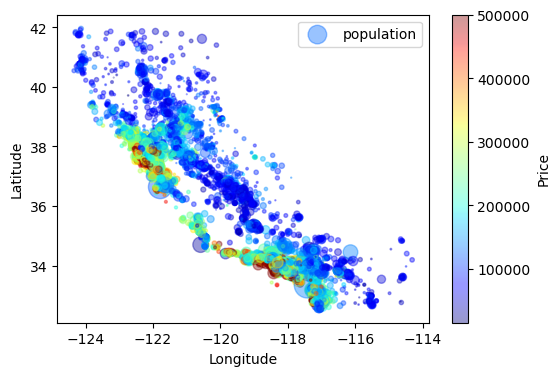

In [91]:
#The radius of each circle represents the district’s population (option s), 
# the color represents the price (option c). 
#We will use a predefined color map (option cmap) called jet, which ranges from blue (low values) to red (high prices):15

plt.figure(figsize=(6, 4))  # Adjust the figure size as needed

# Plotting the scatter plot
scatter = plt.scatter(x=X_train["longitude"], y=X_train["latitude"], alpha=0.4, 
                      s=X_train["population"]/100, label="population", c=y_train, 
                      cmap=plt.get_cmap("jet"))

# Adding colorbar
plt.colorbar(scatter, label='Price')  # Add a color bar with label

# Adding labels and legend
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Display the plot
plt.show()

Interesting....it looks that the closer one gets to the shore, the more expensive the houses become. It seems that, indeed, "Life's a Beach" after all

# Least Square Errors

First, as we did in the first part, let's remove variable that are correlated among them.

In [96]:
varNames = X_train.columns.drop('ocean_proximity')
corr_matrix = X_train[varNames].corr()


correlation_with_y = X_train[varNames].corrwith(y_train)

correlationMatrix_predictor = corr_matrix.to_numpy()
correlationMatrix_response = correlation_with_y.to_numpy()

In [98]:
selectedVariables = removingCorrelatedVariables( correlationMatrix_predictor,  correlationMatrix_response, varNames )
selectedVariables = selectedVariables.tolist() + ['ocean_proximity']

selectedVariables

['latitude',
 'housing_median_age',
 'total_rooms',
 'median_income',
 'ocean_proximity']

We are name the new version of the training and test set as `X_train_filtered` and `X_test_filtered`

In [101]:
X_train_filtered = X_train[selectedVariables]
X_test_filtered = X_test[selectedVariables]

## dummy variables

Before building a regression model, note that the variable 'ocean_proximity' variable is a catgorical variable. That means that we need to convert that variable into dummy variables. To that end, we can use the method pandas.get_dummies()

In [105]:
X_train_filtered['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     6406
INLAND        4635
NEAR OCEAN    1832
NEAR BAY      1572
ISLAND           3
Name: count, dtype: int64

**[5 pts]** Write a function that takes a DataFrame. If the 'ocean_proximity' column is present in the DataFrame, the function creates four dummy variables. We'll designate "<1H OCEAN" as the reference category since it has the most samples (6,406 in total). This implies that when all the dummy variables are set to 0, it represents the "<1H OCEAN" category.

You can modify column values using .loc[condition, col_name] = 1

In [108]:
def getDummies( internal_df ):
    
    if 'ocean_proximity' in internal_df.columns:
        internal_df_dummy = internal_df.copy().drop( 'ocean_proximity', axis=1)

        internal_df_dummy['ISLAND'] = 0
        internal_df_dummy['NEAR BAY'] = 0
        internal_df_dummy['NEAR OCEAN'] = 0
        internal_df_dummy['INLAND'] = 0
        
        # TO DO  ####################################################
        # Assign values to the dummy variables
        internal_df_dummy.loc[internal_df['ocean_proximity'] == 'ISLAND', 'ISLAND'] = 1
        internal_df_dummy.loc[internal_df['ocean_proximity'] == 'NEAR BAY', 'NEAR BAY'] = 1
        internal_df_dummy.loc[internal_df['ocean_proximity'] == 'NEAR OCEAN', 'NEAR OCEAN'] = 1
        internal_df_dummy.loc[internal_df['ocean_proximity'] == 'INLAND', 'INLAND'] = 1
        
        ################################################
    else:
        internal_df_dummy = internal_df
        
    return internal_df_dummy

In [110]:
X_train_dummies = getDummies( X_train_filtered )
X_test_dummies = getDummies( X_test_filtered )
np.sum(X_train_dummies,axis=0)

latitude              5.149244e+05
housing_median_age    4.142710e+05
total_rooms           3.809340e+07
median_income         5.599811e+04
ISLAND                3.000000e+00
NEAR BAY              1.572000e+03
NEAR OCEAN            1.832000e+03
INLAND                4.635000e+03
dtype: float64

### Measuring the predictive performance.

Now, we will use a 10-Fold Cross-Validation to estimate the error of using the selected features.

**[8 pt]** Complete the below function that performs fold cross-validation. For each iteration, you need to calculate the R2 and MSE. Use the following equations:

$MSE = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2$

$R2 = 1 - \frac{\sum_{i=1}^{N} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{N} (y_i - \bar{y} )^2} $

where $\hat{y}_i$ is the prediction and $\bar{y}$ is the mean value for the response variable.

In [114]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error

def perform_CV(X_train_cv, y_val_cv, cat_for_split, folds ):
    skf = StratifiedKFold(n_splits=folds, random_state= 10, shuffle=True )
    
    mse_kfold = np.empty(  folds ) 
    r2_kfold = np.empty(  folds ) 
    
    for i, (train_index, val_index) in enumerate(skf.split(X_train_cv, income_cat_train )):
        X_train_val, X_val = X_train_cv.iloc[ train_index ], X_train_cv.iloc[ val_index ]
        y_train_val, y_val = y_val_cv.iloc[ train_index ], y_val_cv.iloc[ val_index ]
        
        ##     TO DO ###########################################################
        # Train a Linear Regression model
        model = LinearRegression()
        model.fit(X_train_val, y_train_val)

        # Make predictions
        y_pred = model.predict(X_val)
        
        # Calculate MSE
        mse_kfold[i] = mean_squared_error(y_val, y_pred)
        
        # Calculate R2 score
        y_mean = np.mean(y_val)
        ss_total = np.sum((y_val - y_mean) ** 2)
        ss_residual = np.sum((y_val - y_pred) ** 2)
        r2_kfold[i] = 1 - (ss_residual / ss_total)
        
        # complete the function #######################
    return mse_kfold, r2_kfold
    

In [116]:
mse_kfold, r2_kfold = perform_CV(X_train_dummies, y_train, income_cat_train, 10 )

To calculate the performance, we need to take the mean of the individual folds.

In [119]:
mse_mean = np.mean( mse_kfold )
mse_r2 = np.mean( r2_kfold )

print('K-Fold MSE:{} and R2:{}'.format( mse_mean, mse_r2 ) )

K-Fold MSE:5315431594.141207 and R2:0.6052129712614084


Now, let's calculate the error in the test set.

**[5 pts]** Retrain the model in the training set, and calculate the MSE using the test set. Name this variables `test_mse` and `test_r2`. The plot below use those variables, so if you use other names, an error will occur.

In [123]:
# Train a Linear Regression model on the full training set
model = LinearRegression()
model.fit(X_train_dummies, y_train)

# Make predictions on the test set
y_test_pred = model.predict(X_test_dummies)

# Calculate MSE on the test set
test_mse = mean_squared_error(y_test, y_test_pred)

# Calculate R2 score on the test set
y_test_mean = np.mean(y_test)
ss_total_test = np.sum((y_test - y_test_mean) ** 2)
ss_residual_test = np.sum((y_test - y_test_pred) ** 2)
test_r2 = 1 - (ss_residual_test / ss_total_test)# Train a Linear Regression model on the full training set

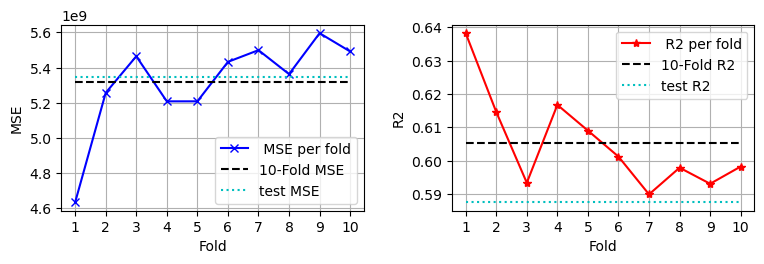

In [125]:
plt.figure(figsize=(8, 3))

plt.subplot(121)
plt.plot( np.arange( 1, 1+len(mse_kfold)  ), mse_kfold, 'bx-' , label=' MSE per fold' )
plt.plot([1, 10 ], [mse_mean, mse_mean ], 'k--', label='10-Fold MSE' )
plt.plot([1, 10 ], [test_mse, test_mse ], 'c:' , label='test MSE')
plt.xticks(np.arange(1,11) )
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.grid()
plt.legend()


plt.subplot(122)
plt.plot(  np.arange( 1, 1+len(mse_kfold)  ), r2_kfold, 'r*-' , label=' R2 per fold')
plt.plot([1, 10 ], [mse_r2, mse_r2 ] , 'k--' , label='10-Fold R2' )
plt.plot([1, 10 ], [test_r2, test_r2 ], 'c:' , label='test R2')
plt.xticks(np.arange(1,11) )
plt.xlabel('Fold')
plt.ylabel('R2')
plt.grid()
plt.legend()

plt.tight_layout(pad=2)  # Increase the spacing between subplots
plt.show()

**[5pts]** Provide intepretation to the plot. How does the test do compared to the estimation given by the CV validation.

MSE Comparison: The test MSE is close to the 10-Fold Cross-Validation MSE, with a difference of less than 0.1.This means that the model's performance on the test set closely matches the cross-validation estimates, indicating good generalization and no signs of overfitting or underfitting.
R-square Comparison:The test R-square value is slightly lower than the average 10-Fold R-square, but the difference is only around 0.02 (2%).This small difference suggests that the model's predictive performance on the test set is consistent with what was estimated during cross-validation.The test R² is approximately 59%, meaning that the model explains 59% of the variance in the target variable.While this indicates a moderate level of explanatory power, there is still room for improvement in capturing additional variation.
Since the test performance closely aligns with cross-validation estimates, the model is neither overfitting nor underfitting and generalizes well to unseen data.Therefore, the test performance validates the cross-validation results, confirming that the model performs reliably across different data splits.

## Gradient descendent


In this part, we are going to write batch gradient descendent. We also will include regularization parameters to train our regression model.

The cost function for the elastic net is defined as:

$ J(b) = \sum_{i=1}^{N} (y_i - X_ib)^2  + \lambda ( \frac{1-\alpha}{2} ||b||_2^2 + \alpha |b| ) $

$ J(b) = \sum_{i=1}^{N} (y_i - X_ib)^2  + \lambda \frac{1-\alpha}{2} ||b||_2^2 +  \lambda \alpha |b|  $

This function can be analyzed as the addition of three functions as:

$f(b)= \sum_{i=1}^{N} (y_i - X_ib)^2 $

$g(b)= \lambda \frac{1-\alpha}{2} ||b||_2^2  $

$z(b)= \lambda \alpha |b| $

so, $ J(b) = f(b) + g(b) + z(b) $


Also, remember that the derivative of the addition of a function is equal to the addition of its derivates. Namely:

$ \frac{\partial J(b) }{ \partial b } =  \frac{\partial f(b) }{ \partial b } + \frac{\partial g(b) }{ \partial b } + \frac{\partial z(b) }{\partial b } $


In class, we reviewed that $ \frac{\partial f(b) }{ \partial b }= -2X^T(y-Xb)$, so what is missing is the derivates for $g(b)$ and $z(b)$.


$g(b) = \lambda \frac{1-\alpha}{2} ||b||_2^2 = \lambda \frac{1-\alpha}{2} (b_0^2 + b_1^2 + ... + b_p^2) $, asumming we have $p$ predictor variables.

$\frac{  \partial [\lambda \frac{1-\alpha}{2} (b_0^2 + b_1^2 + ... + b_p^2) ] }{ \partial b_i }=\lambda(1-\alpha)b_i$


Likewise,

$z(b) = \lambda \alpha |b| = \lambda \alpha  (|b_0| + |b_1| + ... + |b_p|) $, asumming we have $p$ predictor variables.

$\frac{\partial [\lambda \alpha (|b_0| + |b_1| + ... + |b_i| + |b_p|)]}{\partial b_i} = 
\begin{cases}
-\lambda \alpha, & \text{for } b_i < 0 \\
\lambda \alpha, & \text{for } b_i \geq 0
\end{cases} $



**[8 pts]** Write a function that calculates the gradient for elastic net regularization.

Hint: For the l1 gradient, you may want to use the np.sign(array) that returns 1 for the positive entries and -1 for the negative ones. 

In [323]:
# TO DO

def grad(X_in, y_in, b_in, alpha, lambda_value ):
    y_in = y_in.reshape(-1, 1)  # Ensure y_in is a column vector
    
    # Compute gradient of the squared loss term (MSE loss)
    g_f = -2 * X_in.T @ (y_in - X_in @ b_in)
    
    # Compute gradient of the L2 regularization term (Ridge)
    g_g = lambda_value * ((1 - alpha)) * b_in
    g_g[0] = 0
    
    # Compute gradient of the L1 regularization term (Lasso)
    g_z = lambda_value * alpha * np.sign(b_in)
    g_z[0] = 0
    
    # Compute the final gradient
    g = g_f + g_g + g_z  
    
    #note: for the l1 and l2, after calculating the gradiante, make the first entry 0
    # l2_grad[0]=0 and l1_grad[0]=0. The reason is that regularization is not applied to the intercept
    return g


We will write now a function to calculate the batch gradient descedent algorithm.

**[5 pts]** Complete the function to compute the batch gradient descendent optimization

In [363]:
def batch_gradient_descendent(X_train_in, y_train_in,  alpha, lambda_value, eta=1e-4):
    stop = False
    counter = 0
    totalSamples = X_train_in.shape[0]
    b_s = np.random.RandomState(counter).rand(X_train_in.shape[1], 1)

    rList = []
    iterations = 200

    batch_size = 128

    totalSteps = int((totalSamples - batch_size) / batch_size) + 1

    while not stop:
        idx_shuffle = np.random.RandomState(counter).permutation(totalSamples)
        X_train_iter = X_train_in[idx_shuffle]
        y_train_iter = y_train_in[idx_shuffle]

        learningRate = eta / np.sqrt(counter + 1)

        for currStep in range(totalSteps):

            idxStart = currStep * batch_size
            idxEnd = idxStart + batch_size

            # Select the samples for the current batch
            samples = X_train_iter[idxStart:idxEnd]
            
            # TO DO #####################
            #update parameters
            y_batch = y_train_iter[idxStart:idxEnd]

            # Compute gradient using Elastic Net
            gradient = grad(samples, y_batch, b_s, alpha, lambda_value)

            # Update coefficients using gradient descent
            b_s -= learningRate * gradient  # Average over batch
            #################################

        counter += 1
        if counter == iterations:
            stop = True

    return b_s

For the remaining part, we are going to convert the pandas structures to numpy arrays to facilitate the computations.

In [366]:
X_train_2 = X_train_dummies.to_numpy()
y_train_2 = y_train.to_numpy()

# Fix: Ensure X_test_dummies is created
#X_test_dummies = getDummies(X_test_filtered)

X_test_2 = X_test_dummies.to_numpy()
y_test_2 = y_test.to_numpy()


print( X_train_2.shape, y_train_2.shape )
print( X_test_2.shape, y_test_2.shape )

#print(X_train_dummies.columns)
#print(X_test_dummies.columns)

(14448, 8) (14448,)
(6192, 8) (6192,)


The function below, normalized and extend the training and test set given as input.

In [333]:
def processingSet( X_train_in, X_test_in ):
    
    # normalizing
    train_mean = np.mean( X_train_in, axis = 0 )
    train_std = np.std( X_train_in, axis = 0 )

    X_train_in = (X_train_in -train_mean )/(train_std )
    X_test_in = (X_test_in -train_mean )/(train_std )

    ## extending 
    X_train_processed =  np.hstack( [np.ones( [X_train_in.shape[0] ,1]), X_train_in ])
    X_test_processed = np.hstack( [np.ones( [X_test_in.shape[0] ,1]), X_test_in ])
    
    #print( np.mean( X_train_processed, axis = 0 ) )
    #print( np.std( X_train_processed, axis = 0 ) )
    return X_train_processed, X_test_processed

**[8 pts]** Complete the code below to perform 2 fold cross validation on the alpha and lamda values. For each pair, the function `batch_gradient_descendent` need to be call. Using return `beta` you need to calculate the prediction for the `X_val` and calcuate the MSE.

In [336]:
from sklearn.linear_model import ElasticNet

alphas = [ 0, .1 , .3, .5,  .7,  .9, 1]
lambdas = [ 0.001, 0.01, 0.1, 1, 10, 100  ]

MSE = np.empty( [ len( alphas ), len( lambdas ) ] )
folds = 2
for iAlpha in range( len( alphas ) ):
    for iLambda in range( len( lambdas ) ):
        
       
        # perform k Fold
        skf = StratifiedKFold(n_splits=folds, random_state= 0, shuffle=True )
        mse_kfold = np.empty( folds ) 

        for i, (train_index, val_index) in enumerate(skf.split(X_train_2, income_cat_train )):
            X_train_val, X_val = X_train_2[ train_index ], X_train_2[ val_index ]
            y_train_val, y_val = y_train_2[ train_index ], y_train_2[ val_index ]
            
            
            X_train_val, X_val = processingSet( X_train_val, X_val )
            
            ###### TO DO  #####
            # Train using batch gradient descent
            beta = batch_gradient_descendent(X_train_val, y_train_val, alphas[iAlpha], lambdas[iLambda])

            # Make predictions
            y_pred = np.dot(X_val, beta)

            # Compute Mean Squared Error (MSE)
            mse_kfold[i] = np.mean((y_val - y_pred) ** 2)
            #################################################
            
        MSE[ iAlpha, iLambda ] =  np.mean( mse_kfold )
        print('alpha:{} lambda:{}, MSE:{}'.format(alphas[iAlpha], lambdas[iLambda], MSE[ iAlpha, iLambda ] ) )    
MSE              

alpha:0 lambda:0.001, MSE:21635809713.85769
alpha:0 lambda:0.01, MSE:21635343399.427452
alpha:0 lambda:0.1, MSE:21630682783.29162
alpha:0 lambda:1, MSE:21584327960.865097
alpha:0 lambda:10, MSE:21144529758.59395
alpha:0 lambda:100, MSE:18274249110.84813
alpha:0.1 lambda:0.001, MSE:21635814895.276657
alpha:0.1 lambda:0.01, MSE:21635395208.7626
alpha:0.1 lambda:0.1, MSE:21631200391.577248
alpha:0.1 lambda:1, MSE:21589455937.125206
alpha:0.1 lambda:10, MSE:21191367128.58396
alpha:0.1 lambda:100, MSE:18500096799.82218
alpha:0.3 lambda:0.001, MSE:21635825258.131657
alpha:0.3 lambda:0.01, MSE:21635498829.136314
alpha:0.3 lambda:0.1, MSE:21632235778.24163
alpha:0.3 lambda:1, MSE:21599728667.134724
alpha:0.3 lambda:10, MSE:21286512371.771526
alpha:0.3 lambda:100, MSE:19005569292.704563
alpha:0.5 lambda:0.001, MSE:21635835621.00933
alpha:0.5 lambda:0.01, MSE:21635602451.781136
alpha:0.5 lambda:0.1, MSE:21633271391.763557
alpha:0.5 lambda:1, MSE:21610023832.677948
alpha:0.5 lambda:10, MSE:213836

array([[2.16358097e+10, 2.16353434e+10, 2.16306828e+10, 2.15843280e+10,
        2.11445298e+10, 1.82742491e+10],
       [2.16358149e+10, 2.16353952e+10, 2.16312004e+10, 2.15894559e+10,
        2.11913671e+10, 1.85000968e+10],
       [2.16358253e+10, 2.16354988e+10, 2.16322358e+10, 2.15997287e+10,
        2.12865124e+10, 1.90055693e+10],
       [2.16358356e+10, 2.16356025e+10, 2.16332714e+10, 2.16100238e+10,
        2.13836731e+10, 1.95974559e+10],
       [2.16358460e+10, 2.16357061e+10, 2.16343072e+10, 2.16203415e+10,
        2.14829175e+10, 2.02992164e+10],
       [2.16358563e+10, 2.16358097e+10, 2.16353433e+10, 2.16306818e+10,
        2.15843181e+10, 2.11444349e+10],
       [2.16358615e+10, 2.16358615e+10, 2.16358614e+10, 2.16358604e+10,
        2.16358504e+10, 2.16357507e+10]])

In [338]:
MSE_best_lambda =  np.min( MSE, axis=1)
best_alpha_idx = np.argmin( MSE_best_lambda )

best_lambda_idx = np.argmin( MSE[best_alpha_idx,:] )

minMSE = MSE[ best_alpha_idx, best_lambda_idx ]
bestAlpha = alphas[best_alpha_idx]
bestLambda = lambdas[  best_lambda_idx ]

minMSE, np.min( MSE) , bestAlpha, bestLambda

(18274249110.84813, 18274249110.84813, 0, 100)

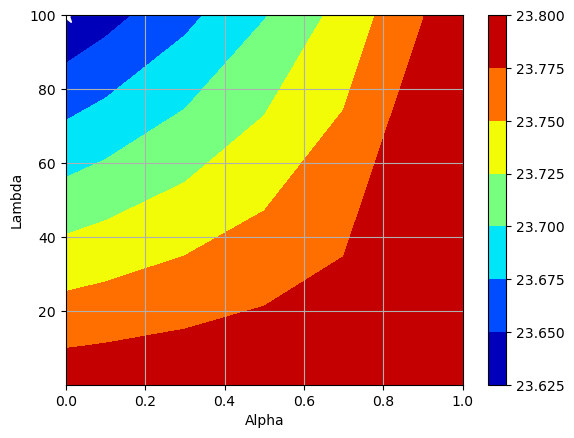

In [340]:
X_grid, Y_grid = np.meshgrid(lambdas, alphas   )
Z_grid =  np.log(MSE )


plt.figure()
plt.contourf(  Y_grid, X_grid, Z_grid , cmap = 'jet', vmin= np.nanmin( Z_grid) , vmax= np.nanmax( Z_grid) )
plt.plot(   alphas[best_alpha_idx], lambdas[  best_lambda_idx ],'w*', markersize=12 )
#plt.axis([ np.nanmin(X_grid), np.nanmax(X_grid), np.nanmin(Y_grid), np.nanmax(Y_grid) ])
#plt.xticks(np.arange(0,8), np.arange(1,8) )
plt.xlabel("Alpha")
plt.ylabel("Lambda")

plt.grid()
plt.colorbar()
#plt.savefig( 'plot3.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

**[4 pts]** Provide interpretation for the figure above. Which type of regularization is better for our training data?

Dark blue areas (low MSE): Indicate better-performing models.Red areas (high MSE): Indicate poorer-performing models. Alpha = 0 corresponds to Ridge Regression (L2 regularization).Alpha = 1 corresponds to Lasso Regression (L1 regularization) and values in between represent Elastic Net, a mix of both.In the figure above, low MSE region is with Alpha <= 0.4 and Lambda => 70 . Therefore, Ridge Regression (L2 regularization) with a moderate to high lambda value seems to be the best choice as it minimizes MSE effectively.Lasso (L1) may not be ideal, possibly because the dataset doesn’t have many irrelevant features to be zeroed out.Elastic Net (mixed approach) might still be useful, but should lean more towards L2 regularization (i.e, alpha < 0.4 , where strong the blue region reside ).

Let's process the data for test.

In [345]:
X_train_extended, X_test_extended = processingSet( X_train_2, X_test_2 )

We recalculate the beta using now all the training data.

In [348]:
b_s = batch_gradient_descendent( X_train_extended, y_train_2, bestAlpha, bestLambda   )
b_s

array([[207118.37341318],
       [ -3157.10486618],
       [  9329.31809572],
       [  6610.33400198],
       [ 52101.10947422],
       [  2170.1185295 ],
       [  6516.39948125],
       [  6139.76483838],
       [-27276.48011021]])

We also calculate the LSE, to compare our beta given by the batch normalization

In [351]:
beta_lse = np.linalg.inv( X_train_extended.T @ X_train_extended) @X_train_extended.T@y_train_2

In [353]:
np.linalg.norm(b_s - beta_lse)

847904.3293045956

**[3 pts]** Calculate the prediction for the test set using the vector `b_s`

In [356]:
yHat_s = X_test_extended @ b_s

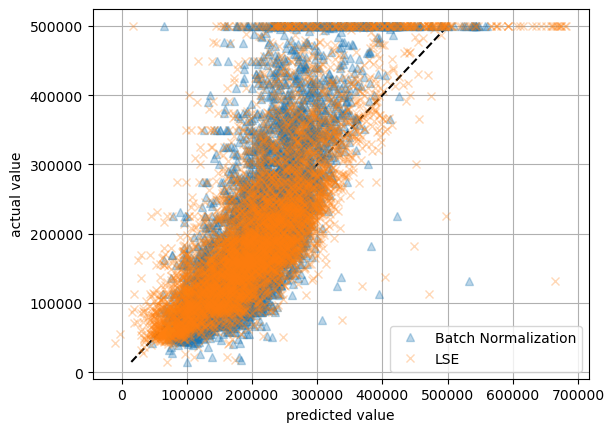

In [358]:
yHat_lse = X_test_extended @ beta_lse


plt.figure( )
plt.plot( [np.min(y_test_2), np.max(y_test_2) ], [ np.min(y_test_2), np.max(y_test_2) ] , '--k') # reference line
plt.plot(yHat_s, y_test_2, '^' , alpha=.3, label= 'Batch Normalization')
plt.plot(yHat_lse, y_test_2, 'x' , alpha=.3, label='LSE')
plt.xlabel( 'predicted value')
plt.ylabel( 'actual value')
plt.legend()
plt.grid()
plt.show()

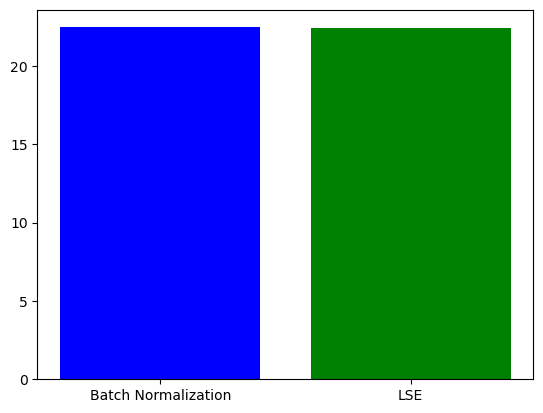

In [360]:
MSE_s = np.mean( (y_test_2- np.squeeze( yHat_s ))**2 )
MSE_lse = np.mean( (y_test_2 - yHat_lse)**2 )

plt.plot()
bars = plt.bar(['Batch Normalization', 'LSE'], [ np.log(MSE_s), np.log(MSE_lse)], color=['blue', 'green'])


**[4 pts]** How did the batch normalization do in comparison to the Least Square Errors?

Since MSE measures the average squared difference between actual and predicted values, a lower MSE indicates better model performance. In the figure above,Batch Normalization (blue bar) has a similar or almost equal MSE result as compared to LSE(Green Bar), it performed well in terms of prediction accuracy. As batch Normalization helps regularize the model, reducing overfitting, models trained with BN often generalize better to new data. 